#### Chapter 10 – Introduction to Artificial Neural Networks with Keras

This notebook contains all the sample code and solutions to the exercises in chapter 10.

# Setup

In [2]:
import sys

assert sys.version_info >= (3, 7)

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [4]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2024-12-12 22:06:26.729564: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# From Biological to Artificial Neurons

## The Perceptron

In [7]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers

In [8]:
y_pred

array([ True, False])

The Perceptron is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [9]:
# extra code – shows how to build and train a Perceptron

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

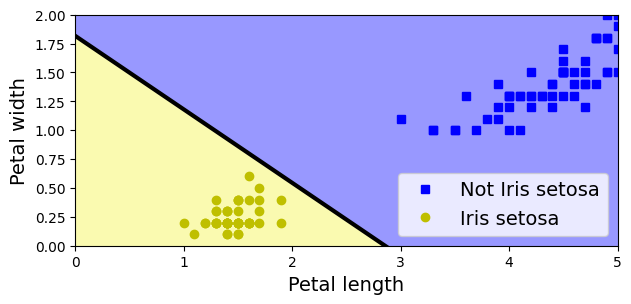

In [10]:
# extra code – plots the decision boundary of a Perceptron on the iris dataset

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

**Activation functions**

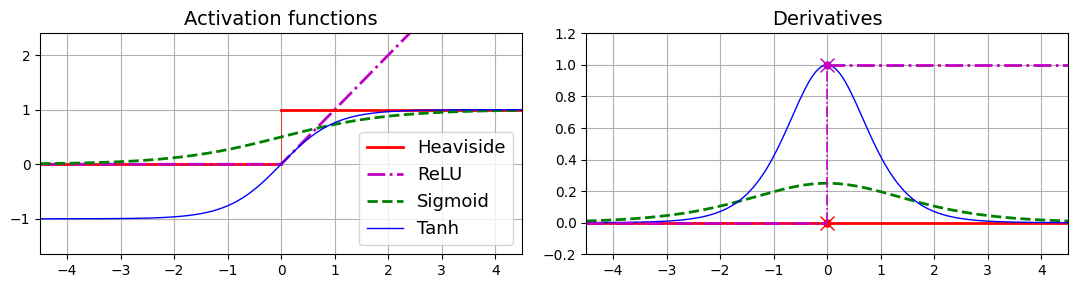

In [11]:
# extra code – this cell generates and saves Figure 10–8

from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## Regression MLPs

In [12]:
import ssl
import urllib.request

# Ignorar a verificação do SSL
ssl._create_default_https_context = ssl._create_unverified_context

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
rmse

0.5053326657968733

## Classification MLPs

In [14]:
# extra code – this was left as an exercise for the reader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementing MLPs with Keras

## Building an Image Classifier Using the Sequential API

### Using Keras to load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in tf.keras.datasets. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [15]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [16]:
X_train.shape

(55000, 28, 28)

In [17]:
X_train[0].shape

(28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [18]:
X_train.dtype

dtype('uint8')

In [19]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [20]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [21]:
X_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

You can plot an image using Matplotlib's imshow() function, with a 'binary' color map:

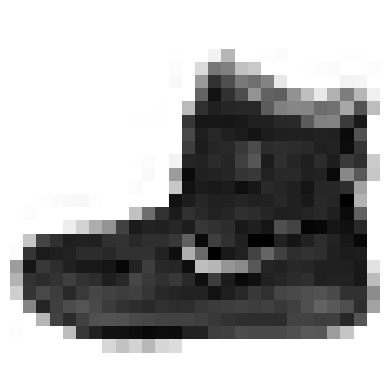

In [22]:
# extra code

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [23]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [24]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is an ankle boot:

In [25]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

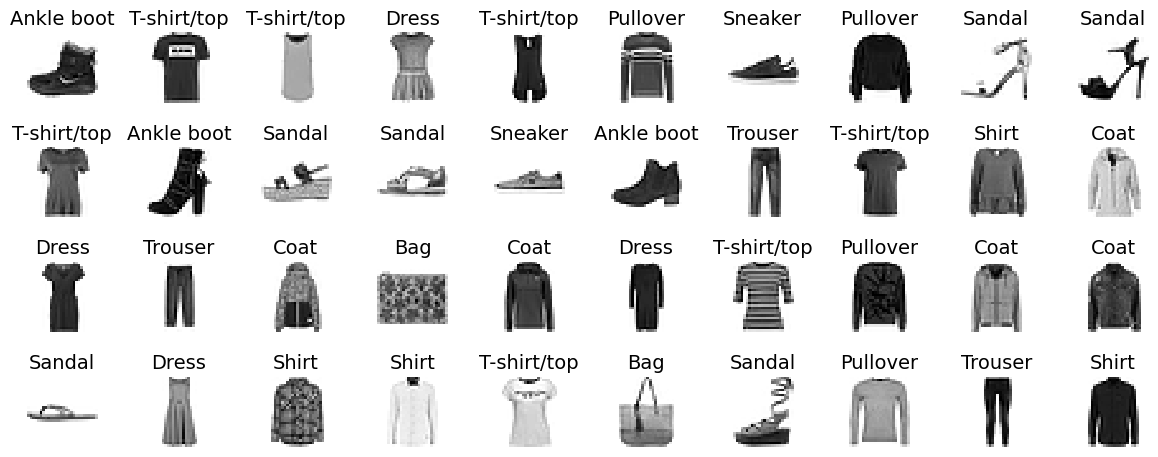

In [26]:
# extra code – this cell generates and saves Figure 10–10

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

### Creating the model using the Sequential API

In [27]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [28]:
# extra code – clear the session to reset the name counters
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# extra code – another way to display the model's architecture
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [31]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [32]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [33]:
model.get_layer('dense') is hidden1

True

In [34]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.04378667, -0.01628989, -0.04130641, ..., -0.03386731,
        -0.01038058, -0.01175402],
       [ 0.02120122,  0.03331838,  0.01006339, ...,  0.00081137,
         0.06924431,  0.02410407],
       [ 0.07084394,  0.0559016 , -0.06978475, ...,  0.0161575 ,
         0.00900921, -0.04042604],
       ...,
       [ 0.060114  ,  0.01734629, -0.01286718, ...,  0.06635199,
         0.05296424, -0.02109472],
       [-0.01825961, -0.06606153, -0.05150246, ...,  0.00968442,
         0.04385009,  0.0372662 ],
       [-0.05742795, -0.00652826, -0.00138756, ..., -0.05012604,
         0.07108328,  0.06182437]], dtype=float32)

In [35]:
weights.shape

(784, 300)

In [36]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [37]:
biases.shape

(300,)

### Compiling the model

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

In [39]:
# extra code – this cell is equivalent to the previous cell
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [40]:
# extra code – shows how to convert class ids to one-hot vectors
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Note: it's important to set `num_classes` when the number of classes is greater than the maximum class id in the sample.

In [41]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0])

### Training and evaluating the model

In [42]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.0273 - sparse_categorical_accuracy: 0.6746 - val_loss: 0.5103 - val_sparse_categorical_accuracy: 0.8250
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5111 - sparse_categorical_accuracy: 0.8252 - val_loss: 0.4555 - val_sparse_categorical_accuracy: 0.8358
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4543 - sparse_categorical_accuracy: 0.8432 - val_loss: 0.4302 - val_sparse_categorical_accuracy: 0.8436
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4232 - sparse_categorical_accuracy: 0.8527 - val_loss: 0.4150 - val_sparse_categorical_accuracy: 0.8484
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4015 - sparse_categorical_accuracy: 0.8599 - val_loss: 0.4046 - val_sparse_categorical_accuracy: 0.8526
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3839 - sparse_categorical_accuracy: 0.8645 - val_loss: 0.3954 - val_sparse_categorical_accuracy: 0.8566
Epo

In [43]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}

In [44]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [45]:
history.history

{'loss': [0.7329182028770447,
  0.4911286532878876,
  0.4438140392303467,
  0.41585564613342285,
  0.39549946784973145,
  0.37896832823753357,
  0.36521416902542114,
  0.3529565632343292,
  0.3420376777648926,
  0.33226048946380615,
  0.3234389126300812,
  0.3153257369995117,
  0.30769431591033936,
  0.30062687397003174,
  0.2938949763774872,
  0.28756120800971985,
  0.28167223930358887,
  0.27600425481796265,
  0.2706543207168579,
  0.265506774187088,
  0.260536253452301,
  0.25585219264030457,
  0.25119149684906006,
  0.24663645029067993,
  0.242220938205719,
  0.23805099725723267,
  0.23386205732822418,
  0.22975721955299377,
  0.2256549894809723,
  0.22170962393283844],
 'sparse_categorical_accuracy': [0.7593454718589783,
  0.8302909135818481,
  0.8459454774856567,
  0.854454517364502,
  0.861090898513794,
  0.8660545349121094,
  0.8705090880393982,
  0.8747272491455078,
  0.878709077835083,
  0.8820000290870667,
  0.885236382484436,
  0.8875272870063782,
  0.890254557132721,
  0.8

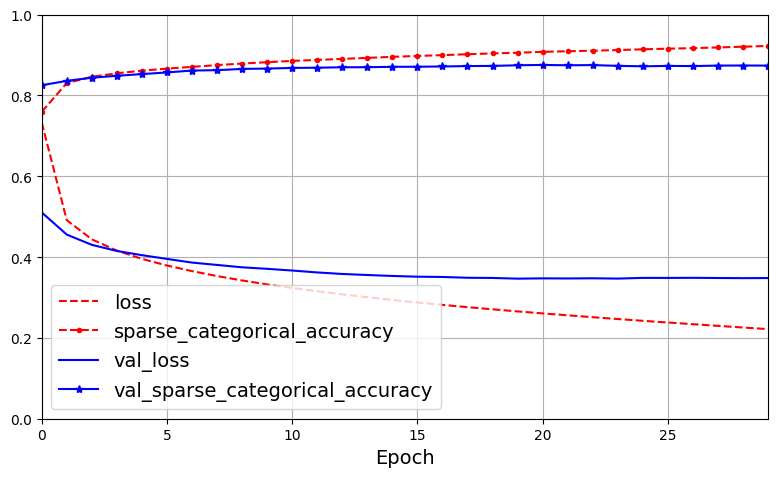

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
save_fig("keras_learning_curves_plot")  # extra code
plt.show()

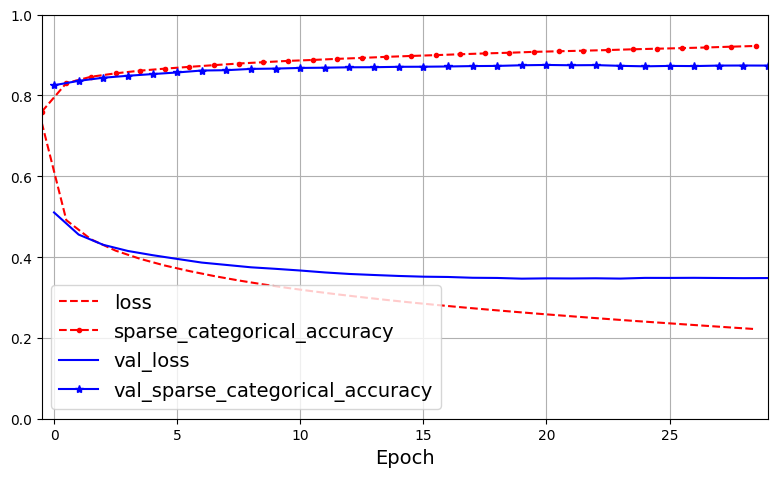

In [47]:
# extra code – shows how to shift the training curve by -1/2 epoch
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
save_fig("keras_learning_curves-0.5_plot")
plt.show()

In [48]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3637 - sparse_categorical_accuracy: 0.8751


[0.36132240295410156, 0.8726999759674072]

### Using the model to make predictions

In [49]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.41, 0.  , 0.02, 0.  , 0.58],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [50]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [51]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [52]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

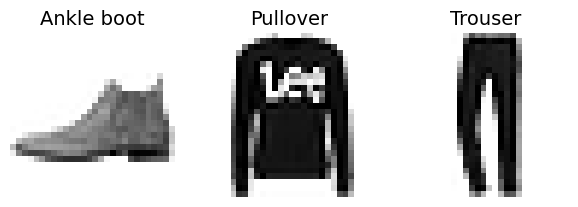

In [53]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

### Building a Regression MLP Using the Sequential API

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [54]:
# extra code – load and split the California housing dataset, like earlier
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [55]:
X_train

array([[   3.5214    ,   15.        ,    3.04994451, ...,    1.60599334,
          37.63      , -122.43      ],
       [   5.3275    ,    5.        ,    6.49005964, ...,    3.44333996,
          33.69      , -117.39      ],
       [   3.1       ,   29.        ,    7.54237288, ...,    2.25084746,
          38.44      , -122.98      ],
       ...,
       [   1.5561    ,   35.        ,    4.13993174, ...,    3.27645051,
          34.11      , -117.29      ],
       [   2.1055    ,   52.        ,    5.17849462, ...,    2.92688172,
          36.76      , -119.79      ],
       [   5.6022    ,   31.        ,    6.21971253, ...,    2.53798768,
          38.04      , -122.2       ]])

In [56]:
shape = X_train.shape
shape

(11610, 8)

In [57]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:

model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])



In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])


In [60]:
norm_layer.adapt(X_train_full)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - RootMeanSquaredError: 1.2694 - loss: 1.7246 - val_RootMeanSquaredError: 0.6655 - val_loss: 0.4429
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6740 - loss: 0.4553 - val_RootMeanSquaredError: 0.6323 - val_loss: 0.3998
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6282 - loss: 0.3951 - val_RootMeanSquaredError: 0.6103 - val_loss: 0.3724
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6121 - loss: 0.3750 - val_RootMeanSquaredError: 0.5968 - val_loss: 0.3562
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6011 - loss: 0.3616 - val_RootMeanSquaredError: 0.5857 - val_loss: 0.3430
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.5913 - loss: 0.3499 - val_RootMeanSquaredError: 0.5755 - val_loss: 0.3312
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.5828 - loss: 0.3399 -

In [61]:
history.history

{'RootMeanSquaredError': [0.9589919447898865,
  0.6421198844909668,
  0.6113598346710205,
  0.5981189608573914,
  0.5878522396087646,
  0.5788614749908447,
  0.571858286857605,
  0.5654832720756531,
  0.5591627955436707,
  0.5543026328086853,
  0.550569474697113,
  0.5470454096794128,
  0.5428583025932312,
  0.5405900478363037,
  0.5398918390274048,
  0.5355796813964844,
  0.5371381044387817,
  0.5339457988739014,
  0.5297238826751709,
  0.5265231132507324],
 'loss': [0.919665515422821,
  0.4123179316520691,
  0.37376081943511963,
  0.35774627327919006,
  0.34557023644447327,
  0.3350805938243866,
  0.32702192664146423,
  0.31977131962776184,
  0.3126630187034607,
  0.3072513937950134,
  0.303126722574234,
  0.29925864934921265,
  0.2946951687335968,
  0.2922375798225403,
  0.29148322343826294,
  0.2868455648422241,
  0.2885173261165619,
  0.285098135471344,
  0.2806074023246765,
  0.2772265672683716],
 'val_RootMeanSquaredError': [0.6654937863349915,
  0.6322805285453796,
  0.61025834

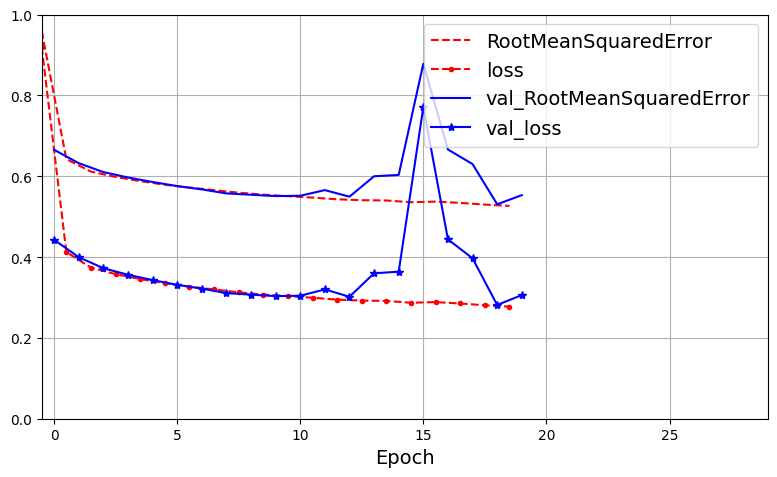

In [62]:
# extra code – shows how to shift the training curve by -1/2 epoch
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="upper right")
plt.grid()
save_fig("keras_learning_curves_regression_-0.5_plot")
plt.show()

In [63]:
mse_test, rmse_test = model.evaluate(X_test, y_test)


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5417 - loss: 0.2936


In [64]:
mse_test

0.2976379990577698

In [65]:
rmse_test

0.5455620884895325

In [66]:
X_new = X_test[:3]
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


In [67]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

In [68]:
y_pred

array([[0.5146048],
       [1.063351 ],
       [4.6154375]], dtype=float32)

# Building Complex Models Using the Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network connects all or part of the inputs directly to the output layer.

In [69]:
# extra code – reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [70]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [71]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 8)         │         17 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30)        │        270 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │        930 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

In [72]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - RootMeanSquaredError: 1.5867 - loss: 2.6431 - val_RootMeanSquaredError: 1.0329 - val_loss: 1.0668
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.7403 - loss: 0.5500 - val_RootMeanSquaredError: 0.6945 - val_loss: 0.4823
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6660 - loss: 0.4440 - val_RootMeanSquaredError: 1.7884 - val_loss: 3.1982
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6436 - loss: 0.4146 - val_RootMeanSquaredError: 1.3318 - val_loss: 1.7738
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6258 - loss: 0.3918 - val_RootMeanSquaredError: 1.2899 - val_loss: 1.6639
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6161 - loss: 0.3799 - val_RootMeanSquaredError: 1.0033 - val_loss: 1.0066
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6043 - loss: 0.3654 -

In [73]:
tf.random.set_seed(42)  # extra code

In [74]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [75]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_6', 'keras_tensor_7']. Received: the structure of inputs=('*', '*')
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - RootMeanSquaredError: 1.3254 - loss: 1.8211 - val_RootMeanSquaredError: 1.5693 - val_loss: 2.4627
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.7329 - loss: 0.5381 - val_RootMeanSquaredError: 0.7787 - val_loss: 0.6064
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6731 - loss: 0.4535 - val_RootMeanSquaredError: 0.6414 - val_loss: 0.4114
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6540 - loss: 0.4281 - val_RootMeanSquaredError: 0.6129 - val_loss: 0.3756
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6428 - loss: 0.4136 - val_RootMeanSquaredError: 0.6063 - val_loss: 0.3676
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6337 - loss: 0.4019 - val_RootMeanSquaredError: 0.6205 - val_loss: 0.3850
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6260 - loss: 0.3921 -

In [76]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [77]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

**Warning:** in recent versions, Keras requires one metric per output, so I replaced `metrics=["RootMeanSquaredError"]` with `metrics=["RootMeanSquaredError", "RootMeanSquaredError"]` in the code below.

In [78]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError", "RootMeanSquaredError"])

In [79]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - dense_2_RootMeanSquaredError: 1.7389 - dense_2_loss: 2.8281 - dense_3_RootMeanSquaredError: 1.6265 - dense_3_loss: 0.2698 - loss: 3.0979 - val_dense_2_RootMeanSquaredError: 0.8642 - val_dense_2_loss: 0.6720 - val_dense_3_RootMeanSquaredError: 2.1127 - val_dense_3_loss: 0.4461 - val_loss: 1.1185
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - dense_2_RootMeanSquaredError: 0.8440 - dense_2_loss: 0.6416 - dense_3_RootMeanSquaredError: 0.9072 - dense_3_loss: 0.0824 - loss: 0.7240 - val_dense_2_RootMeanSquaredError: 0.7876 - val_dense_2_loss: 0.5582 - val_dense_3_RootMeanSquaredError: 1.4875 - val_dense_3_loss: 0.2212 - val_loss: 0.7796
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - dense_2_RootMeanSquaredError: 0.7526 - dense_2_loss: 0.5101 - dense_3_RootMeanSquaredError: 0.7997 - dense_3_loss: 0.0640 - loss: 0.5740 - val_dense_2_RootMeanSquaredError: 0.6847 - val_dense_2_loss: 0.4219 - val_dense_3_RootMeanSquaredError: 1.1145 - val_d

In [80]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
print(eval_results)

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - dense_2_RootMeanSquaredError: 0.5732 - dense_2_loss: 0.2958 - dense_3_RootMeanSquaredError: 0.6241 - dense_3_loss: 0.0390 - loss: 0.3347
[0.3299526572227478, 0.2912991940975189, 0.03833619877696037, 0.5692376494407654, 0.6190668344497681]


In [81]:
weighted_sum_of_losses, main_loss, aux_loss = eval_results[:3]

In [86]:
weighted_sum_of_losses

0.3299526572227478

In [87]:
main_loss

0.2912991940975189

In [88]:
aux_loss

0.03833619877696037

In [82]:

y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


In [83]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [89]:
y_pred

{'dense_2': array([[0.41089195],
        [1.1482937 ],
        [3.6949983 ]], dtype=float32),
 'dense_3': array([[0.3570684],
        [0.8601561],
        [3.563659 ]], dtype=float32)}

## Using the Subclassing API to Build Dynamic Models

In [90]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

**Warning:** as explained above, Keras now requires one metric per output, so I replaced `metrics=["RootMeanSquaredError"] `with `metrics=["RootMeanSquaredError", "RootMeanSquaredError"]` in the code below.

In [91]:

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError", "RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - RootMeanSquaredError: 1.5521 - RootMeanSquaredError_1: 1.8051 - loss: 2.6219 - mse_loss: 0.3350 - val_RootMeanSquaredError: 1.2129 - val_RootMeanSquaredError_1: 1.5245 - val_loss: 1.5565 - val_mse_loss: 0.2323
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - RootMeanSquaredError: 0.7310 - RootMeanSquaredError_1: 0.9130 - loss: 0.5647 - mse_loss: 0.0835 - val_RootMeanSquaredError: 0.6557 - val_RootMeanSquaredError_1: 0.8830 - val_loss: 0.4649 - val_mse_loss: 0.0779
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6784 - RootMeanSquaredError_1: 0.7905 - loss: 0.4769 - mse_loss: 0.0625 - val_RootMeanSquaredError: 0.6892 - val_RootMeanSquaredError_1: 0.7311 - val_loss: 0.4809 - val_mse_loss: 0.0534
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - RootMeanSquaredError: 0.6505 - RootMeanSquaredError_1: 0.7455 - loss: 0.4366 - mse_loss: 0.0556 - val_RootMeanSquaredError: 0.6572 - val_RootMeanSquaredEr

## Saving and Restoring a Model

**Warning:** Keras now recommends using the .keras format to save models, and the `h5` format for weights. Therefore I have updated the code in this section to first show what you need to change if you still want to use TensorFlow's `SavedModel` format, and then how you can use the recommended formats.

In [92]:
# extra code – delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

**Warning:** Keras's `model.save()` method no longer supports TensorFlow's `SavedModel` format. However, you can still export models to the `SavedModel` format using `model.export()` like this:

In [93]:
model.export("my_keras_model")

INFO:tensorflow:Assets written to: my_keras_model/assets


INFO:tensorflow:Assets written to: my_keras_model/assets


Saved artifact at 'my_keras_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): Tuple[TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)]
Output Type:
  Tuple[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  5323018608: TensorSpec(shape=(1, 5), dtype=tf.float32, name=None)
  5323026528: TensorSpec(shape=(1, 5), dtype=tf.float32, name=None)
  5323023008: TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
  5323024416: TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
  5338074096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5338075680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5338084656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5338078144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5338076560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  533808430

In [94]:
# extra code – show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model/assets
my_keras_model/fingerprint.pb
my_keras_model/saved_model.pb
my_keras_model/variables
my_keras_model/variables/variables.data-00000-of-00001
my_keras_model/variables/variables.index


**Warning:** In Keras 3, it is no longer possible to load a TensorFlow SavedModel as a Keras model. However, you can load a `SavedModel` as a `tf.keras.layers.TFSMLayer` layer, but be aware that this layer can only be used for inference: no training.

In [95]:
tfsm_layer = tf.keras.layers.TFSMLayer("my_keras_model")
y_pred_main, y_pred_aux = tfsm_layer((X_new_wide, X_new_deep))

Warning: Keras now requires the saved weights to have the .weights.h5 extension. There are no longer saved using the SavedModel format.

In [96]:
model.save_weights("my_weights.weights.h5")

In [97]:
model.load_weights("my_weights.weights.h5")

To save a model using the .keras format, simply use model.save():

In [98]:
model.save("my_model.keras")

To load a .keras model, use the tf.keras.models.load_model() function. If the model uses any custom object, you must pass them to the function via the custom_objects argument:

In [99]:
loaded_model = tf.keras.models.load_model(
    "my_model.keras",
    custom_objects={"WideAndDeepModel": WideAndDeepModel}
)

## Using Callbacks

In [100]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # extra code

**Warning:** as explained earlier, Keras now requires the checkpoint files to have a `.weights.h5` extension:

In [101]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints.weights.h5",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.6100 - RootMeanSquaredError_1: 0.6618 - loss: 0.3789 - mse_loss: 0.0438 - val_RootMeanSquaredError: 1.6959 - val_RootMeanSquaredError_1: 1.0213 - val_loss: 2.6928 - val_mse_loss: 0.1043
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - RootMeanSquaredError: 0.6040 - RootMeanSquaredError_1: 0.6603 - loss: 0.3720 - mse_loss: 0.0436 - val_RootMeanSquaredError: 1.3764 - val_RootMeanSquaredError_1: 1.0019 - val_loss: 1.8053 - val_mse_loss: 0.1004
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5954 - RootMeanSquaredError_1: 0.6523 - loss: 0.3617 - mse_loss: 0.0426 - val_RootMeanSquaredError: 1.0737 - val_RootMeanSquaredError_1: 0.7290 - val_loss: 1.0908 - val_mse_loss: 0.0531
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5905 - RootMeanSquaredError_1: 0.6482 - loss: 0.3559 - mse_loss: 0.0420 - val_RootMeanSquaredError: 1.0247 - val_RootMeanSquaredEr

In [102]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - RootMeanSquaredError: 0.5811 - RootMeanSquaredError_1: 0.6297 - loss: 0.3437 - mse_loss: 0.0397 - val_RootMeanSquaredError: 1.0561 - val_RootMeanSquaredError_1: 0.7975 - val_loss: 1.0674 - val_mse_loss: 0.0636
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.5778 - RootMeanSquaredError_1: 0.6280 - loss: 0.3400 - mse_loss: 0.0394 - val_RootMeanSquaredError: 1.2676 - val_RootMeanSquaredError_1: 1.3493 - val_loss: 1.6281 - val_mse_loss: 0.1820
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - RootMeanSquaredError: 0.5776 - RootMeanSquaredError_1: 0.6270 - loss: 0.3396 - mse_loss: 0.0393 - val_RootMeanSquaredError: 1.0185 - val_RootMeanSquaredError_1: 0.8960 - val_loss: 1.0140 - val_mse_loss: 0.0802
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - RootMeanSquaredError: 0.5761 - RootMeanSquaredError_1: 0.6268 - loss: 0.3380 - mse_loss: 0.0393 - val_RootMeanSquaredError: 1.2412 - val_RootMeanSquar

In [103]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [104]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

Epoch=0, val/train=2.04
Epoch=1, val/train=1.21
Epoch=2, val/train=2.37
Epoch=3, val/train=1.02
Epoch=4, val/train=2.12
Epoch=5, val/train=1.15
Epoch=6, val/train=2.59
Epoch=7, val/train=1.07
Epoch=8, val/train=2.30
Epoch=9, val/train=1.21


# Using TensorBoard for Visualization

TensorBoard is preinstalled on Colab, but not the `tensorboard-plugin-profile`, so let's install it

In [105]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

In [106]:
shutil.rmtree("my_logs", ignore_errors=True)

In [107]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [108]:
# extra code – builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [109]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

2024-12-13 23:05:57.155815: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-12-13 23:05:57.156155: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-12-13 23:05:57.162255: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


Epoch 1/20
180/363 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 2.2193 - loss: 5.0580

2024-12-13 23:05:58.858148: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-12-13 23:05:58.858240: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


200/363 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - RootMeanSquaredError: 2.1709 - loss: 4.8533

2024-12-13 23:05:59.237319: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-12-13 23:05:59.297770: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-12-13 23:05:59.305659: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: my_logs/run_2024_12_13_23_05_34/plugins/profile/2024_12_13_23_05_59/MacBook-Pro-de-vinicius-rondon.local.xplane.pb


363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - RootMeanSquaredError: 1.9026 - loss: 3.7874 - val_RootMeanSquaredError: 0.9633 - val_loss: 0.9280
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.9366 - loss: 0.8782 - val_RootMeanSquaredError: 0.8416 - val_loss: 0.7082
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.8648 - loss: 0.7485 - val_RootMeanSquaredError: 0.7990 - val_loss: 0.6383
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.8308 - loss: 0.6908 - val_RootMeanSquaredError: 0.7694 - val_loss: 0.5919
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.8033 - loss: 0.6459 - val_RootMeanSquaredError: 0.7442 - val_loss: 0.5538
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.7791 - loss: 0.6076 - val_RootMeanSquaredError: 0.7222 - val_loss: 0.5216
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.7575 - loss: 0.5744 -

In [110]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2024_12_13_23_05_34
    plugins
      profile
        2024_12_13_23_05_59
          MacBook-Pro-de-vinicius-rondon.local.xplane.pb
    train
      events.out.tfevents.1734141957.MacBook-Pro-de-vinicius-rondon.local.706.0.v2
    validation
      events.out.tfevents.1734141959.MacBook-Pro-de-vinicius-rondon.local.706.1.v2


In [111]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

Note: if you prefer to access TensorBoard in a separate tab, click the "localhost:6006" link below:

In [112]:
# extra code

if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

You can use also visualize histograms, images, text, and even listen to audio using TensorBoard:

In [113]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)


Note: it used to be possible to easily share your TensorBoard logs with the world by uploading them to https://tensorboard.dev/. Sadly, this service will shut down in December 2023, so I have removed the corresponding code examples from this notebook.

When you stop this Jupyter kernel (a.k.a. Runtime), it will automatically stop the TensorBoard server as well. Another way to stop the TensorBoard server is to kill it, if you are running on Linux or MacOSX. First, you need to find its process ID:

In [114]:
# extra code – lists all running TensorBoard server instances

from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./my_logs (started 0:08:34 ago; pid 9797)


# Fine-Tuning Neural Network Hyperparameters

In this section we'll use the Fashion MNIST dataset again:

In [115]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [116]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [117]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner~=1.4.6

In [119]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [120]:

random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 58s]
val_accuracy: 0.8416000008583069

Best val_accuracy So Far: 0.8429999947547913
Total elapsed time: 00h 06m 28s


In [121]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [122]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 8,
 'n_neurons': 37,
 'learning_rate': 0.008547485565344062,
 'optimizer': 'sgd'}

In [123]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 3 summary
Hyperparameters:
n_hidden: 8
n_neurons: 37
learning_rate: 0.008547485565344062
optimizer: sgd
Score: 0.8429999947547913


In [124]:
best_trial.metrics.get_last_value("val_accuracy")

0.8429999947547913

In [125]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8577 - loss: 0.3852
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8598 - loss: 0.3759
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8650 - loss: 0.3631
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8671 - loss: 0.3568
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8682 - loss: 0.3513
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8712 - loss: 0.3439
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8725 - loss: 0.3399
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8730 - loss: 0.3378
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8743 - loss: 0.3359
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8750 - loss: 0.3307
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8445 - loss: 0.4461


In [126]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [127]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [128]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 47s]
val_accuracy: 0.847000002861023

Best val_accuracy So Far: 0.8730000257492065
Total elapsed time: 00h 30m 18s


In [129]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 39s]
val_accuracy: 0.8338000178337097

Best val_accuracy So Far: 0.8575999736785889
Total elapsed time: 00h 06m 18s


In [130]:
%tensorboard --logdir {root_logdir}